install dask for fast data loading

In [ ]:
!pip install dask

import libraries

In [2]:
import dask.dataframe as dd
import csv
import re
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

loading the dataset using dask library

In [ ]:
csv_path = "/content/drive/MyDrive/Copy of complaints.csv"
parquet_path = "/content/drive/MyDrive/Processed_complaints.parquet"

# Define dtypes explicitly
dtypes = {
    'Complaint ID': 'float64',
    'Date received': 'object',
    'Product': 'object',
    'Sub-product': 'object',
    'Issue': 'object',
    'Sub-issue': 'object',
    'Consumer complaint narrative': 'object',
    'Company public response': 'object',
    'Company': 'object',
    'State': 'object',
    'ZIP code': 'object',
    'Tags': 'object',
    'Consumer consent provided?': 'object',
    'Submitted via': 'object',
    'Date sent to company': 'object',
    'Company response to consumer': 'object',
    'Timely response?': 'object',
    'Consumer disputed?': 'object'
}

# Load CSV with Dask
ddf = dd.read_csv(
    csv_path,
    dtype=dtypes,
    on_bad_lines='skip',
    quoting=csv.QUOTE_MINIMAL,
    escapechar='\\',
    engine='python',
    assume_missing=True  # helpful if there are NaNs in numeric cols
)

# Parse date columns explicitly
ddf['Date received'] = dd.to_datetime(ddf['Date received'], errors='coerce')
ddf['Date sent to company'] = dd.to_datetime(ddf['Date sent to company'], errors='coerce')

# Save as parquet for faster reloads later
ddf.to_parquet(parquet_path, engine="pyarrow", write_index=False)

# Optional: print out a sample to verify
ddf.head()


KeyboardInterrupt: 

In [3]:
parquet_path = "/content/drive/MyDrive/Processed_complaints.parquet"
df = dd.read_parquet(parquet_path)

In [ ]:
#  Null/empty count
print(df.isnull().sum().compute())

Date received                       190
Product                              67
Sub-product                      235381
Issue                               127
Sub-issue                        839650
Consumer complaint narrative    6629194
Company public response         4770339
Company                             157
State                             54673
ZIP code                          30389
Tags                            8981134
Consumer consent provided?      1649735
Submitted via                       166
Date sent to company                193
Company response to consumer        207
Timely response?                    191
Consumer disputed?              8841635
Complaint ID                        193
dtype: int64


In [7]:
# Count complaints per product
product_counts = df['Product'].value_counts().compute()

# Plot
plt.figure(figsize=(50, 15))
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Complaints Across Products")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

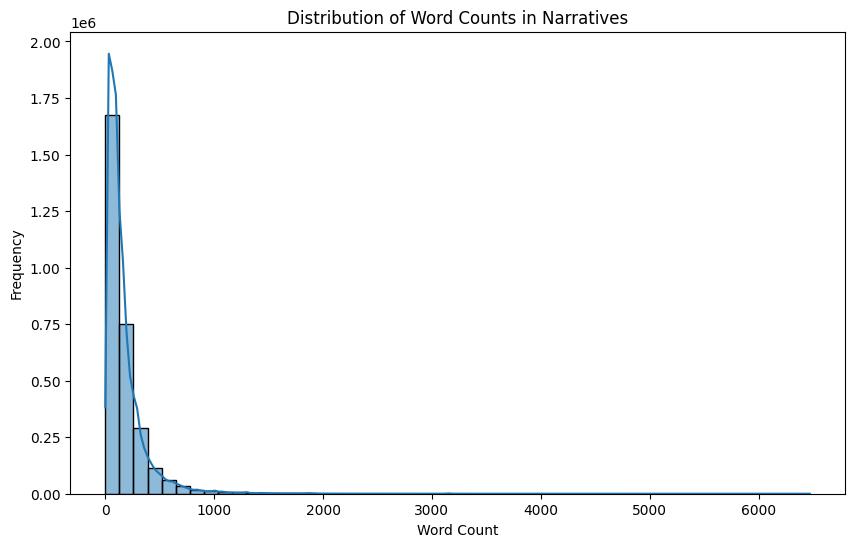

Narrative Word Count Stats:
count    2.980739e+06
mean     1.755925e+02
std      2.259225e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: word_count, dtype: float64


In [ ]:
# Drop rows with missing narratives
narrative_df = df[~df['Consumer complaint narrative'].isnull()]

# Compute word counts
narrative_df = narrative_df.assign(
    word_count=narrative_df['Consumer complaint narrative'].str.split().str.len()
)

# Convert to pandas for plotting
narrative_pd = narrative_df[['word_count']].compute()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(narrative_pd['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts in Narratives")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Show stats
print("Narrative Word Count Stats:")
print(narrative_pd['word_count'].describe())

In [9]:
# With narrative
with_narrative = df['Consumer complaint narrative'].notnull().sum().compute()

# Without narrative
without_narrative = df['Consumer complaint narrative'].isnull().sum().compute()

print(f"✅ Complaints with narrative: {with_narrative}")
print(f"❌ Complaints without narrative: {without_narrative}")


✅ Complaints with narrative: 2980739
❌ Complaints without narrative: 6629194


In [10]:
target_products = [
    "Credit card",
    "Personal loan",
    "Buy Now, Pay Later (BNPL)",
    "Savings account",
    "Money transfers"
]

# Filter
filtered_df = df[
    (df['Product'].isin(target_products)) &
    (df['Consumer complaint narrative'].notnull())
]


In [11]:
# Define cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove special chars
    text = re.sub(r"\bi am writing to file a complaint\b", "", text)
    return text.strip()

# Apply cleaning using map_partitions
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].map_partitions(
    lambda part: part.apply(clean_text),
    meta=('Consumer complaint narrative', 'object')
)


In [12]:
output_path = "/content/drive/MyDrive/final_processed_complaints.csv"
filtered_df[['Product', 'cleaned_narrative']].to_csv(output_path, single_file=True, index=False)
print(f"✅ Filtered and cleaned data saved to {output_path}")


✅ Filtered and cleaned data saved to /content/drive/MyDrive/final_processed_complaints.csv
